In [1]:
#The main Jupyter notebook for running our simulation. For now we can also use this notebook to test out code segments
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import CSJModel as csj

In [2]:
#Model Parameters
model_params = {
                'n_days': 200,
                'plot_capacity': 1000,
                'initial_sat': 0.5,
                'initial_plot_biomass': 100,
                'base_drainage_rate': 0.02,
                'transpiration_rate': 0.002,
                'root_retention': 0.0003
            }

In [3]:
#Weather Treatments

#Rain Frequency
base_rain_frequency = 0.125
rainy = 0.4
drought = 0.01

#Rain Amount
base_rain_amount = 0.3
deluge = 0.4
drizzle = 0.1

#Variability
base_std = 0.1
variable = 0.2
predictable = 0.01

In [4]:
#Plant Species Parameter Dictionary List
plant_dicts = [
                #0: Control Plant: "moderate"/middle values for all parameters
                {
                    'name': 'control',
                    'growth_rate': 0.025,
                    'ideal_sat': 0.5,
                    'sat_alpha': 15,
                    'percent_root': 0.5
                },
    
                #1: Speedy: high growth rate
                {
                    'name': 'Speedy',
                    'growth_rate': 0.05,
                    'ideal_sat': 0.5,
                    'sat_alpha': 15,
                    'percent_root': 0.5
                },
    
                #2: Pokey: low growth rate
                {
                    'name': 'Pokey',
                    'growth_rate': 0.01,
                    'ideal_sat': 0.5,
                    'sat_alpha': 15,
                    'percent_root': 0.5
                },
    
                #3: Swampy: likes wet soil
                {
                    'name': 'Swampy',
                    'growth_rate': 0.025,
                    'ideal_sat': 0.75,
                    'sat_alpha': 15,
                    'percent_root': 0.5
                },
    
                #4: Dusty: likes dry soil
                {
                    'name': 'Dusty',
                    'growth_rate': 0.025,
                    'ideal_sat': 0.25,
                    'sat_alpha': 15,
                    'percent_root': 0.05
                },
    
                #5: Fussy: has a narrower range of soil saturation tolerance
                {
                    'name': 'Fussy',
                    'growth_rate': 0.025,
                    'ideal_sat': 0.5,
                    'sat_alpha': 50,
                    'percent_root': 0.5
                },
    
                #6: Chill: has a wider range of soil saturation tolerance
                {
                    'name': 'Chill',
                    'growth_rate': 0.025,
                    'ideal_sat': 0.5,
                    'sat_alpha': 5,
                    'percent_root': 0.5
                },
    
                #7: Rudy: invests more biomass in roots
                {
                    'name': 'Rudy',
                    'growth_rate': 0.025,
                    'ideal_sat': 0.5,
                    'sat_alpha': 15,
                    'percent_root': 0.7
                },
    
                #8: Leif: invests more biomass in leaves
                {
                    'name': 'Leif',
                    'growth_rate': 0.025,
                    'ideal_sat': 0.5,
                    'sat_alpha': 15,
                    'percent_root': 0.3
                }
            ]

In [5]:
plot_combos = [
                #0 - 8: Monocultures
                [0], [1], [2], [3], [4], [5], [6], [7], [8],
    
                #9 - 16: Control + Treatment pairs
                (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8),
    
                #17 - 20: Pairwise combos of opposing treatments
                (1, 2), (3, 4), (5, 6), (7, 8),
    
                #21 - 24: Arbitrary pairwise cross-treatment combos
                (1, 4), (2, 7), (3, 6), (5, 8),
    
                #25 - 34: Control + 3 Treatments
                (0, 1, 2, 3), (0, 2, 3, 4), (0, 3, 4, 5), (0, 4, 5, 6), (0, 5, 6, 7),
                (0, 6, 7, 8), (0, 1, 3, 5), (0, 2, 4, 6), (0, 3, 5, 8), (0, 1, 4, 7),
    
                #35: All species
                (0, 1, 2, 3, 4, 5, 6, 7, 8)
            ]

In [ ]:
#Monte Carlo Simulation
control_trials_direct = []
drought_drizzle_direct = []
control_trials_niches = []
drought_drizzle_niches = []
n_trials = 1000
direct_comp = 1.0
niches = 0.6
 
for trial in range(n_trials):
    print(f'Trial {trial}')
    control_trials_direct.extend(csj.run_trial(trial, model_params, plant_dicts, plot_combos, direct_comp, base_rain_frequency, base_std, base_rain_amount, base_std))
    drought_drizzle_direct.extend(csj.run_trial(trial, model_params, plant_dicts, plot_combos, direct_comp, drought, base_std, drizzle, base_std))
    control_trials_niches.extend(csj.run_trial(trial, model_params, plant_dicts, plot_combos, niches, base_rain_frequency, base_std, base_rain_amount, base_std))
    drought_drizzle_niches.extend(csj.run_trial(trial, model_params, plant_dicts, plot_combos, niches, drought, base_std, drizzle, base_std))

control_direct_df = pd.DataFrame.from_records(control_trials_direct, index=['plot_index', 'trial', 'day'])
drought_drizzle_direct_df = pd.DataFrame.from_records(drought_drizzle_direct, index=['plot_index', 'trial', 'day'])
control_niches_df = pd.DataFrame.from_records(control_trials_niches, index=['plot_index', 'trial', 'day'])
drought_drizzle_niches_df = pd.DataFrame.from_records(drought_drizzle_niches, index=['plot_index', 'trial', 'day'])


control_direct_df.to_csv('control_with_direct_comp_1k.csv')
drought_drizzle_direct_df.to_csv('drought_drizzle_direct_comp_1k.csv')
control_niches_df.to_csv('control_with_niches_1k.csv')
drought_drizzle_niches_df.to_csv('drought_drizzle_niches_1k.csv')


In [17]:
frame_list[0].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['total_biomass']].mean().values[0]

999.9538604305184

In [2]:
control_direct_df = pd.read_csv('control_with_direct_comp_1k.csv', index_col=['plot_index','trial','day'])
drought_drizzle_direct_df = pd.read_csv('drought_drizzle_direct_comp_1k.csv', index_col=['plot_index','trial','day'])
control_niches_df = pd.read_csv('control_with_niches_1k.csv', index_col=['plot_index','trial','day'])
drought_drizzle_niches_df = pd.read_csv('drought_drizzle_niches_1k.csv', index_col=['plot_index','trial','day'])

In [ ]:
#summary stats averaging each plots performance (each plants biomass) across the 1000 trials
frame_list = [control_direct_df, drought_drizzle_direct_df, control_niches_df, drought_drizzle_niches_df]
dict_list = []
for i in range(len(frame_list)):
    for plot_ind in range(36):
        match i:
            case 0:
                summary_point = {'treatment': 'control_direct', 'plot_index': plot_ind}
            case 1:
                summary_point = {'treatment': 'drought_direct', 'plot_index': plot_ind}
            case 2:
                summary_point = {'treatment': 'control_niches', 'plot_index': plot_ind}
            case _:
                summary_point = {'treatment': 'drought_niches', 'plot_index': plot_ind}
        
        summary_point['total_biomass_mean'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['total_biomass']].mean().values[0]
        summary_point['total_biomass_std'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['total_biomass']].std().values[0]
        summary_point['total_biomass_min'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['total_biomass']].min().values[0]
        summary_point['total_biomass_med'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['total_biomass']].median().values[0]
        summary_point['total_biomass_max'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['total_biomass']].max().values[0]

        summary_point['control_biomass_mean'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['control_biomass']].mean().values[0]
        summary_point['control_biomass_std'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['control_biomass']].std().values[0]
        summary_point['control_biomass_min'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['control_biomass']].min().values[0]
        summary_point['control_biomass_med'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['control_biomass']].median().values[0]
        summary_point['control_biomass_max'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['control_biomass']].max().values[0]

        summary_point['Speedy_biomass_mean'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Speedy_biomass']].mean().values[0]
        summary_point['Speedy_biomass_std'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Speedy_biomass']].std().values[0]
        summary_point['Speedy_biomass_min'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Speedy_biomass']].min().values[0]
        summary_point['Speedy_biomass_med'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Speedy_biomass']].median().values[0]
        summary_point['Speedy_biomass_max'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Speedy_biomass']].max().values[0]

        summary_point['Pokey_biomass_mean'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Pokey_biomass']].mean().values[0]
        summary_point['Pokey_biomass_std'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Pokey_biomass']].std().values[0]
        summary_point['Pokey_biomass_min'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Pokey_biomass']].min().values[0]
        summary_point['Pokey_biomass_med'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Pokey_biomass']].median().values[0]
        summary_point['Pokey_biomass_max'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Pokey_biomass']].max().values[0]

        summary_point['Swampy_biomass_mean'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Swampy_biomass']].mean().values[0]
        summary_point['Swampy_biomass_std'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Swampy_biomass']].std().values[0]
        summary_point['Swampy_biomass_min'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Swampy_biomass']].min().values[0]
        summary_point['Swampy_biomass_med'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Swampy_biomass']].median().values[0]
        summary_point['Swampy_biomass_max'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Swampy_biomass']].max().values[0]

        summary_point['Dusty_biomass_mean'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Dusty_biomass']].mean().values[0]
        summary_point['Dusty_biomass_std'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Dusty_biomass']].std().values[0]
        summary_point['Dusty_biomass_min'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Dusty_biomass']].min().values[0]
        summary_point['Dusty_biomass_med'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Dusty_biomass']].median().values[0]
        summary_point['Dusty_biomass_max'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Dusty_biomass']].max().values[0]

        summary_point['Fussy_biomass_mean'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Fussy_biomass']].mean().values[0]
        summary_point['Fussy_biomass_std'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Fussy_biomass']].std().values[0]
        summary_point['Fussy_biomass_min'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Fussy_biomass']].min().values[0]
        summary_point['Fussy_biomass_med'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Fussy_biomass']].median().values[0]
        summary_point['Fussy_biomass_max'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Fussy_biomass']].max().values[0]

        summary_point['Chill_biomass_mean'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Chill_biomass']].mean().values[0]
        summary_point['Chill_biomass_std'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Chill_biomass']].std().values[0]
        summary_point['Chill_biomass_min'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Chill_biomass']].min().values[0]
        summary_point['Chill_biomass_med'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Chill_biomass']].median().values[0]
        summary_point['Chill_biomass_max'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Chill_biomass']].max().values[0]

        summary_point['Rudy_biomass_mean'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Rudy_biomass']].mean().values[0]
        summary_point['Rudy_biomass_std'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Rudy_biomass']].std().values[0]
        summary_point['Rudy_biomass_min'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Rudy_biomass']].min().values[0]
        summary_point['Rudy_biomass_med'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Rudy_biomass']].median().values[0]
        summary_point['Rudy_biomass_max'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Rudy_biomass']].max().values[0]

        summary_point['Leif_biomass_mean'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Leif_biomass']].mean().values[0]
        summary_point['Leif_biomass_std'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Leif_biomass']].std().values[0]
        summary_point['Leif_biomass_min'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Leif_biomass']].min().values[0]
        summary_point['Leif_biomass_med'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Leif_biomass']].median().values[0]
        summary_point['Leif_biomass_max'] = frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][['Leif_biomass']].max().values[0]

        dict_list.append(summary_point)

summary_df = pd.DataFrame.from_records(dict_list, index=['treatment','plot_index'])


In [7]:
summary_df.loc['control_direct'].loc[35]

total_biomass_mean      999.989916
total_biomass_std         0.019973
total_biomass_min       999.576019
total_biomass_med       999.994438
total_biomass_max       999.999751
control_biomass_mean     91.904393
control_biomass_std       3.413397
control_biomass_min      75.400569
control_biomass_med      92.320597
control_biomass_max     101.459964
Speedy_biomass_mean     373.615462
Speedy_biomass_std       18.053353
Speedy_biomass_min      284.343592
Speedy_biomass_med      376.320949
Speedy_biomass_max      422.486973
Pokey_biomass_mean       28.283851
Pokey_biomass_std         0.517608
Pokey_biomass_min        25.732572
Pokey_biomass_med        28.346041
Pokey_biomass_max        29.727303
Swampy_biomass_mean       0.189155
Swampy_biomass_std        0.300110
Swampy_biomass_min        0.000702
Swampy_biomass_med        0.089962
Swampy_biomass_max        4.664133
Dusty_biomass_mean      166.031005
Dusty_biomass_std        25.331437
Dusty_biomass_min        79.993275
Dusty_biomass_med   

In [4]:
summary_df.to_csv('summary.csv')

In [21]:
#a histogram of each plots total biomass at the end of the 10-year simulation
col_list = ['total_biomass','control_biomass','Speedy_biomass','Pokey_biomass','Swampy_biomass','Dusty_biomass','Fussy_biomass','Chill_biomass','Rudy_biomass','Leif_biomass']
for i in range(len(frame_list)):
    for plot_ind in range(35):
        for col in col_list:
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
            match i:
                case 0:
                    fig.suptitle('Control with Direct Competition: Plot ' + str(plot_ind) + ' Day 199 ' + col + ' Distribution')
                case 1:
                    fig.suptitle('Drought with Direct Competition: Plot ' + str(plot_ind) + ' Day 199 ' + col + ' Distribution')
                case 2:
                    fig.suptitle('Control with Niches: Plot ' + str(plot_ind) + ' Day 199 ' + col + ' Distribution')
                case _:
                    fig.suptitle('Drought with Niches: Plot ' + str(plot_ind) + ' Day 199 ' + col + ' Distribution')
            frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][[col]].hist(ax=ax, bins=range(0, 1501, 10))
            fig.savefig(str(i) + '_' + str(plot_ind) + '_' + col + '_hist.png')
            plt.close()

In [ ]:
#a histogram of each plots total biomass at the end of the 10-year simulation
col_list = ['control_biomass','Speedy_biomass','Pokey_biomass','Swampy_biomass','Dusty_biomass','Fussy_biomass','Chill_biomass','Rudy_biomass','Leif_biomass']
for i in range(len(frame_list)):
    for plot_ind in range(35):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
        match i:
            case 0:
                fig.suptitle('Control with Direct Competition: Plot ' + str(plot_ind) + ' Day 199 All Columns Distribution')
            case 1:
                fig.suptitle('Drought with Direct Competition: Plot ' + str(plot_ind) + ' Day 199 All Columns Distribution')
            case 2:
                fig.suptitle('Control with Niches: Plot ' + str(plot_ind) + ' Day 199 All Columns Distribution')
            case _:
                fig.suptitle('Drought with Niches: Plot ' + str(plot_ind) + ' Day 199 ' + col + ' Distribution')
        ax.hist(x=frame_list[i].reorder_levels(['day','plot_index','trial']).loc[199].loc[plot_ind][col_list], bins=range(0, 1411, 10), density=True, stacked=True)
        fig.savefig(str(i) + '_' + str(plot_ind) + '_all_cols_hist.png')
        plt.close()

In [ ]:
#graph of rain fall

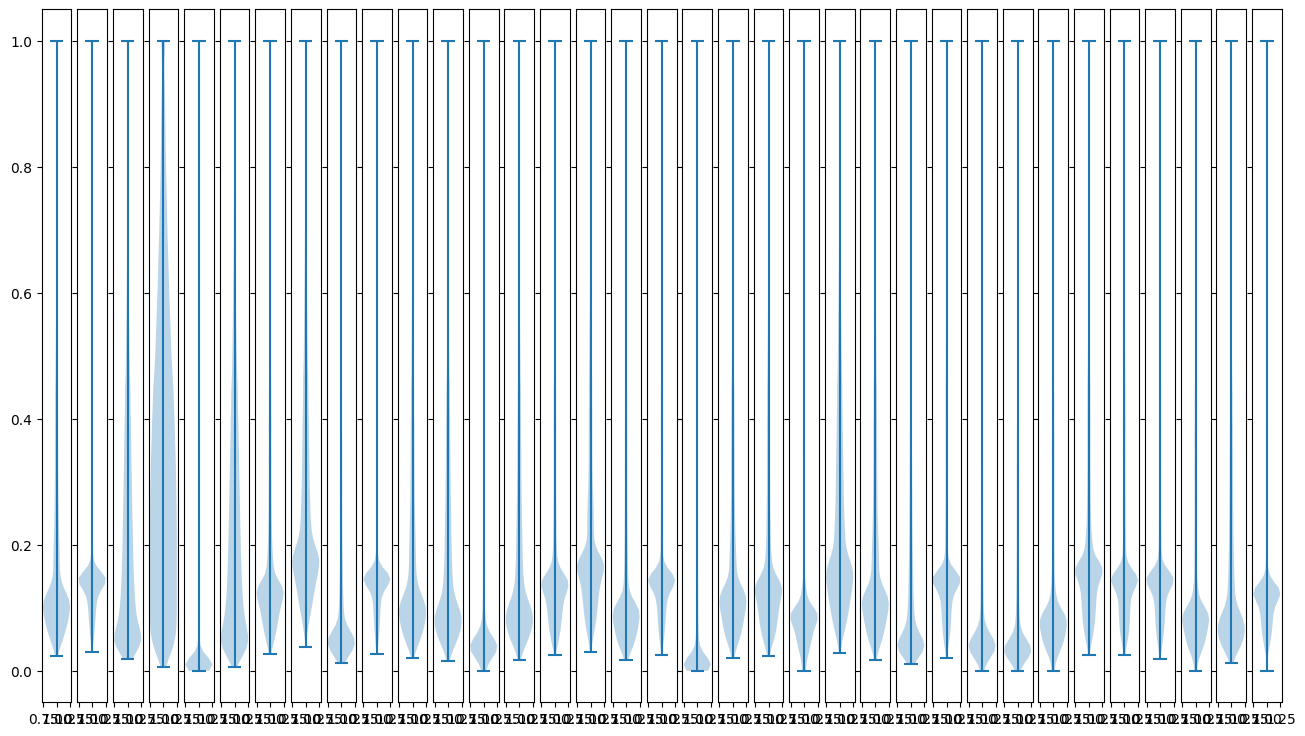

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=35, sharey=True, figsize=(16, 9))
for plot_num in range(35):
    ax[plot_num].violinplot(control_direct_df.reset_index(level=['trial','day']).loc[plot_num][['soil_sat']])

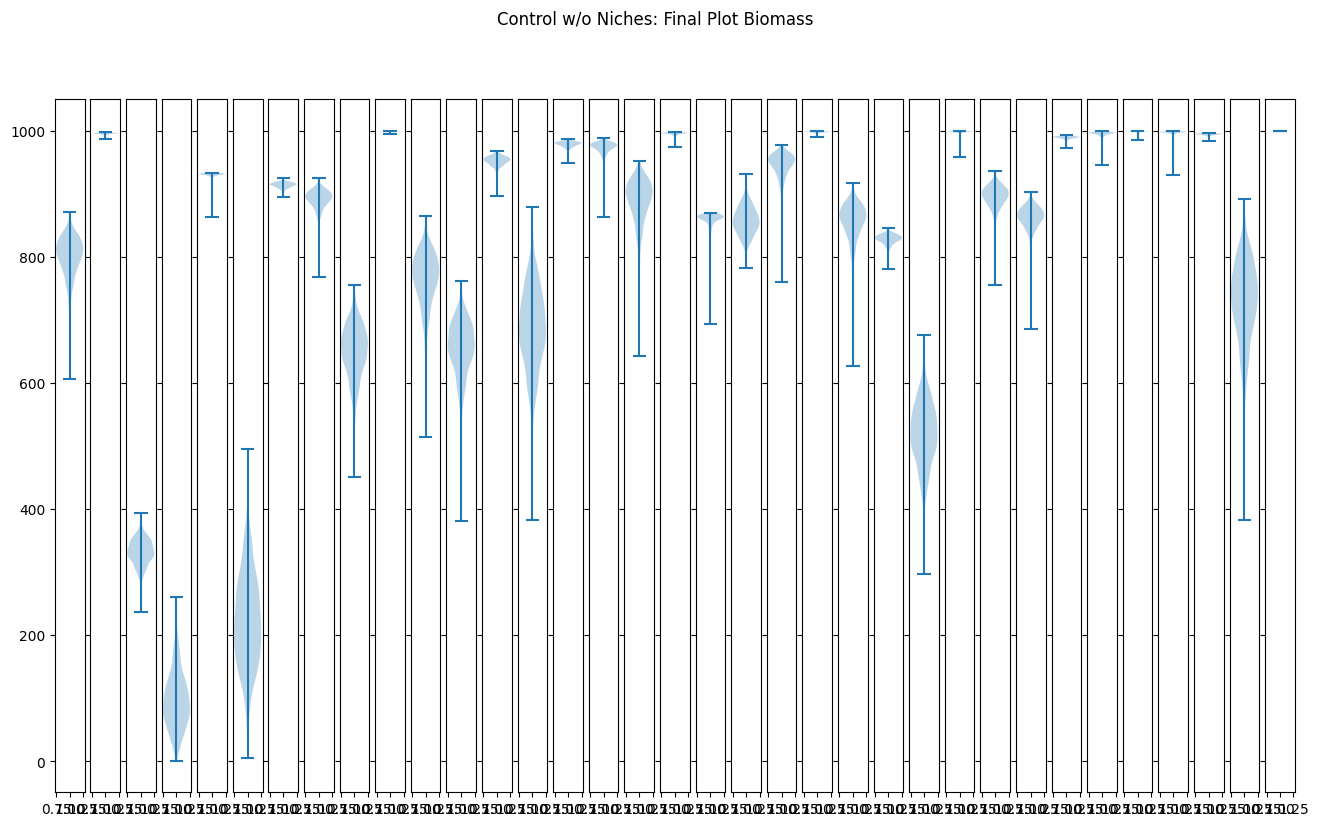

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=35, sharey=True, figsize=(16,9))
for plot_ind in range(35):
    ax[plot_ind].violinplot(control_direct_df.reorder_levels(['day', 'plot_index','trial']).loc[199].loc[plot_ind][['control_biomass', 'Speedy_biomass','Pokey_biomass','Swampy_biomass','Dusty_biomass','Fussy_biomass','Chill_biomass','Rudy_biomass','Leif_biomass']].sum(axis='columns'))
    fig.suptitle("Control w/o Niches: Final Plot Biomass")

In [11]:
control_direct_df.reset_index(['plot_index','trial','day'])[['plot_index','soil_sat']].groupby('plot_index').describe()


soil_sat                                                    \
               count      mean       std       min       25%       50%   
plot_index                                                               
0           200000.0  0.194195  0.160456  0.022686  0.087414  0.119763   
1           200000.0  0.192466  0.139550  0.029590  0.120802  0.145844   
2           200000.0  0.237008  0.189441  0.018735  0.078929  0.185226   
3           200000.0  0.356276  0.230927  0.006206  0.170186  0.318046   
4           200000.0  0.078762  0.133938  0.000000  0.007919  0.012338   
5           200000.0  0.245061  0.195322  0.006244  0.083562  0.195371   
6           200000.0  0.194860  0.154801  0.026697  0.098630  0.130762   
7           200000.0  0.287108  0.182668  0.038530  0.157449  0.216745   
8           200000.0  0.138442  0.149119  0.012226  0.042592  0.060239   
9           200000.0  0.195844  0.142545  0.027269  0.122445  0.147723   
10          200000.0  0.200846  0.167200  0.020972  0.084378  0.123425   
11          200000.0  0.207992  0.173478  0.015384  0.079416  0.137710   
12          200000.0  0.115410  0.144606  0.000000  0.032718  0.046007   
13          200000.0  0.198320  0.167221  0.016819  0.079082  0.124146   
14          200000.0  0.197209  0.153021  0.025568  0.104078  0.140215   
15          200000.0  0.236808  0.164085  0.030106  0.130994  0.172254   
16          200000.0  0.162905  0.150602  0.017412  0.068505  0.096811   
17          200000.0  0.196307  0.146047  0.025537  0.116073  0.145787   
18          200000.0  0.104583  0.154516  0.000000  0.008407  0.014185   
19          200000.0  0.196434  0.160891  0.019901  0.090032  0.125048   
20          200000.0  0.195912  0.156084  0.023163  0.096334  0.134277   
21          200000.0  0.135363  0.136591  0.000000  0.060051  0.086848   
22          200000.0  0.258820  0.177992  0.028074  0.131435  0.190132   
23          200000.0  0.203163  0.166203  0.017813  0.089740  0.124993   
24          200000.0  0.159408  0.162384  0.010121  0.041683  0.083319   
25          200000.0  0.199760  0.150565  0.020312  0.113523  0.146798   
26          200000.0  0.138744  0.160130  0.000000  0.036381  0.052366   
27          200000.0  0.135335  0.160948  0.000000  0.030928  0.045803   
28          200000.0  0.148270  0.150767  0.000000  0.056922  0.084015   
29          200000.0  0.219509  0.158796  0.025183  0.119289  0.162894   
30          200000.0  0.199423  0.151957  0.024791  0.108500  0.146782   
31          200000.0  0.198615  0.150309  0.018073  0.111827  0.146390   
32          200000.0  0.151213  0.150633  0.000000  0.060258  0.088672   
33          200000.0  0.177950  0.164530  0.012516  0.062857  0.098098   
34          200000.0  0.174042  0.143859  0.000000  0.092716  0.123721   
35          200000.0  0.179253  0.149221  0.000000  0.090173  0.125779   

                           
                 75%  max  
plot_index                 
0           0.261753  1.0  
1           0.186387  1.0  
2           0.345980  1.0  
3           0.499785  1.0  
4           0.076325  1.0  
5           0.357055  1.0  
6           0.244055  1.0  
7           0.383722  1.0  
8           0.190325  1.0  
9           0.197511  1.0  
10          0.279644  1.0  
11          0.299891  1.0  
12          0.139678  1.0  
13          0.279098  1.0  
14          0.238970  1.0  
15          0.299875  1.0  
16          0.209595  1.0  
17          0.211865  1.0  
18          0.161354  1.0  
19          0.264091  1.0  
20          0.249361  1.0  
21          0.128775  1.0  
22          0.351811  1.0  
23          0.281024  1.0  
24          0.235085  1.0  
25          0.231190  1.0  
26          0.204428  1.0  
27          0.203547  1.0  
28          0.187389  1.0  
29          0.273783  1.0  
30          0.236281  1.0  
31          0.230037  1.0  
32          0.188164  1.0  
33          0.254956  1.0  
34          0.179546  1.0  
35          0.209178  1.0

In [12]:
drought_drizzle_direct_df.reset_index(['plot_index','trial','day'])[['plot_index','soil_sat']].groupby('plot_index').describe()


soil_sat                                                    \
               count      mean       std       min       25%       50%   
plot_index                                                               
0           200000.0  0.078580  0.071561  0.022686  0.039389  0.056970   
1           200000.0  0.113138  0.067771  0.029590  0.065013  0.110300   
2           200000.0  0.072074  0.079514  0.018225  0.025929  0.036023   
3           200000.0  0.172667  0.130864  0.000741  0.069968  0.143995   
4           200000.0  0.025334  0.055828  0.000000  0.006192  0.010211   
5           200000.0  0.116380  0.107902  0.000460  0.033321  0.082832   
6           200000.0  0.102331  0.068451  0.026697  0.057773  0.092788   
7           200000.0  0.126508  0.081600  0.037974  0.072905  0.107989   
8           200000.0  0.049747  0.065601  0.012226  0.019321  0.026327   
9           200000.0  0.110352  0.069910  0.027269  0.058521  0.104531   
10          200000.0  0.075107  0.073885  0.020956  0.035059  0.049470   
11          200000.0  0.073349  0.078620  0.012938  0.027932  0.042157   
12          200000.0  0.043256  0.061598  0.000000  0.018551  0.025845   
13          200000.0  0.071561  0.077515  0.014065  0.027536  0.040722   
14          200000.0  0.102032  0.069956  0.025568  0.054035  0.090897   
15          200000.0  0.107411  0.075878  0.030106  0.057266  0.089218   
16          200000.0  0.064484  0.067456  0.017412  0.029639  0.043472   
17          200000.0  0.103464  0.070337  0.025537  0.053545  0.092645   
18          200000.0  0.030989  0.065158  0.000000  0.005499  0.009386   
19          200000.0  0.088056  0.071378  0.019893  0.043068  0.072273   
20          200000.0  0.083086  0.070884  0.023163  0.041666  0.063253   
21          200000.0  0.060203  0.059731  0.000000  0.029017  0.048050   
22          200000.0  0.099723  0.078654  0.027738  0.051290  0.076249   
23          200000.0  0.089016  0.072231  0.017752  0.043340  0.073284   
24          200000.0  0.054131  0.074087  0.007803  0.014411  0.021567   
25          200000.0  0.094078  0.072659  0.020299  0.043731  0.076937   
26          200000.0  0.046989  0.068307  0.000000  0.017715  0.024209   
27          200000.0  0.043085  0.069485  0.000000  0.013182  0.018594   
28          200000.0  0.066182  0.064964  0.000000  0.030109  0.051221   
29          200000.0  0.103542  0.074408  0.025183  0.051764  0.086858   
30          200000.0  0.101234  0.071370  0.024791  0.050838  0.087046   
31          200000.0  0.089935  0.073192  0.017461  0.040365  0.071482   
32          200000.0  0.070230  0.064452  0.000000  0.033939  0.056211   
33          200000.0  0.062561  0.075660  0.010548  0.020967  0.031548   
34          200000.0  0.084125  0.065681  0.000000  0.042730  0.072423   
35          200000.0  0.081836  0.068539  0.000000  0.037565  0.066134   

                                
                 75%       max  
plot_index                      
0           0.080594  0.774473  
1           0.141333  0.768071  
2           0.084530  0.778254  
3           0.244006  1.000000  
4           0.013399  0.667896  
5           0.167251  0.908040  
6           0.122992  0.774465  
7           0.146839  0.846780  
8           0.041860  0.708433  
9           0.143003  0.770739  
10          0.075717  0.776124  
11          0.084479  0.774613  
12          0.033472  0.700416  
13          0.080691  0.774149  
14          0.128439  0.774129  
15          0.129990  0.809536  
16          0.063521  0.740303  
17          0.132935  0.772719  
18          0.012968  0.701033  
19          0.104498  0.774145  
20          0.092430  0.774133  
21          0.065263  0.697397  
22          0.112144  0.811629  
23          0.105340  0.774608  
24          0.059596  0.740318  
25          0.122241  0.773465  
26          0.032775  0.737413  
27          0.027921  0.736456  
28          0.073471  0.736172  
29          0.133068  0.791472  
30          0.132764  0.773946  
31 

In [13]:
control_niches_df.reset_index(['plot_index','trial','day'])[['plot_index','soil_sat']].groupby('plot_index').describe()


soil_sat                                                    \
               count      mean       std       min       25%       50%   
plot_index                                                               
0           200000.0  0.194259  0.159649  0.022686  0.087895  0.119773   
1           200000.0  0.192762  0.139292  0.029590  0.121360  0.145905   
2           200000.0  0.236600  0.187787  0.018225  0.078942  0.186224   
3           200000.0  0.354193  0.228903  0.009538  0.170121  0.316773   
4           200000.0  0.078912  0.133784  0.000000  0.007958  0.012368   
5           200000.0  0.242797  0.192251  0.004525  0.082954  0.194490   
6           200000.0  0.195109  0.154320  0.026697  0.099017  0.130913   
7           200000.0  0.287303  0.181548  0.037974  0.158234  0.217681   
8           200000.0  0.138374  0.148452  0.012226  0.042785  0.060308   
9           200000.0  0.204745  0.142247  0.027296  0.122005  0.167290   
10          200000.0  0.201044  0.165847  0.020966  0.085569  0.125046   
11          200000.0  0.207301  0.171706  0.012983  0.079730  0.137983   
12          200000.0  0.116906  0.144109  0.000000  0.032862  0.048825   
13          200000.0  0.197919  0.165649  0.014439  0.080069  0.124491   
14          200000.0  0.202259  0.151947  0.025587  0.106724  0.151660   
15          200000.0  0.242382  0.162052  0.030129  0.135550  0.192205   
16          200000.0  0.164237  0.149692  0.000000  0.069082  0.101474   
17          200000.0  0.199259  0.145333  0.025558  0.118578  0.151350   
18          200000.0  0.104605  0.154129  0.000000  0.008437  0.014236   
19          200000.0  0.196689  0.159638  0.019904  0.091019  0.127541   
20          200000.0  0.199100  0.154719  0.023178  0.098932  0.143663   
21          200000.0  0.141212  0.137470  0.000000  0.059091  0.094704   
22          200000.0  0.259628  0.176017  0.027755  0.134092  0.191468   
23          200000.0  0.202911  0.164930  0.017759  0.090137  0.125496   
24          200000.0  0.158865  0.161219  0.008377  0.041828  0.083440   
25          200000.0  0.206525  0.149713  0.020312  0.114496  0.162561   
26          200000.0  0.139198  0.159408  0.000000  0.036812  0.055069   
27          200000.0  0.135465  0.160125  0.000000  0.031348  0.047713   
28          200000.0  0.153127  0.150604  0.000000  0.057216  0.092164   
29          200000.0  0.228769  0.157510  0.025198  0.122802  0.185241   
30          200000.0  0.210787  0.152347  0.000000  0.107804  0.170018   
31          200000.0  0.204862  0.149371  0.017475  0.112944  0.160435   
32          200000.0  0.156956  0.150848  0.000000  0.060363  0.097550   
33          200000.0  0.177691  0.162993  0.010686  0.063874  0.099610   
34          200000.0  0.188363  0.147462  0.000000  0.093370  0.149986   
35          200000.0  0.193598  0.153096  0.000000  0.089125  0.150663   

                           
                 75%  max  
plot_index                 
0           0.261719  1.0  
1           0.186283  1.0  
2           0.345393  1.0  
3           0.495428  1.0  
4           0.076877  1.0  
5           0.354334  1.0  
6           0.245031  1.0  
7           0.384173  1.0  
8           0.190697  1.0  
9           0.197985  1.0  
10          0.279162  1.0  
11          0.298948  1.0  
12          0.138373  1.0  
13          0.278286  1.0  
14          0.238846  1.0  
15          0.299451  1.0  
16          0.209106  1.0  
17          0.210533  1.0  
18          0.161365  1.0  
19          0.263243  1.0  
20          0.249140  1.0  
21          0.157128  1.0  
22          0.350792  1.0  
23          0.280342  1.0  
24          0.234710  1.0  
25          0.231181  1.0  
26          0.204466  1.0  
27          0.203566  1.0  
28          0.193668  1.0  
29          0.273943  1.0  
30          0.245493  1.0  
31          0.229931  1.0  
32          0.197305  1.0  
33          0.254027  1.0  
34          0.220252  1.0  
35          0.245319  1.0

In [14]:
drought_drizzle_niches_df.reset_index(['plot_index','trial','day'])[['plot_index','soil_sat']].groupby('plot_index').describe()


soil_sat                                                    \
               count      mean       std       min       25%       50%   
plot_index                                                               
0           200000.0  0.077483  0.070952  0.022686  0.038736  0.056135   
1           200000.0  0.112035  0.067516  0.029590  0.063607  0.108973   
2           200000.0  0.071063  0.078906  0.018225  0.025580  0.035024   
3           200000.0  0.172274  0.133705  0.001968  0.066433  0.142378   
4           200000.0  0.024905  0.055278  0.000000  0.006105  0.010145   
5           200000.0  0.116511  0.110375  0.000834  0.032144  0.081600   
6           200000.0  0.101474  0.067970  0.026697  0.056974  0.092122   
7           200000.0  0.124819  0.080907  0.037974  0.071536  0.106199   
8           200000.0  0.049045  0.065074  0.012226  0.018979  0.025966   
9           200000.0  0.115119  0.072876  0.027296  0.057948  0.106032   
10          200000.0  0.074134  0.073213  0.020966  0.034454  0.049007   
11          200000.0  0.072285  0.078031  0.012943  0.027107  0.041415   
12          200000.0  0.043111  0.060918  0.000000  0.018300  0.025874   
13          200000.0  0.070626  0.077015  0.014072  0.026820  0.040169   
14          200000.0  0.104562  0.071114  0.025587  0.053438  0.091476   
15          200000.0  0.107774  0.075967  0.030129  0.056346  0.088803   
16          200000.0  0.063771  0.066859  0.017421  0.029135  0.043015   
17          200000.0  0.103967  0.070687  0.025558  0.052491  0.092278   
18          200000.0  0.030330  0.064356  0.000000  0.005404  0.009285   
19          200000.0  0.087142  0.070757  0.019904  0.042316  0.071458   
20          200000.0  0.082578  0.070381  0.023178  0.040947  0.062741   
21          200000.0  0.063988  0.060823  0.000000  0.028507  0.048995   
22          200000.0  0.098575  0.077989  0.027755  0.050310  0.075409   
23          200000.0  0.087949  0.071545  0.017759  0.042735  0.072307   
24          200000.0  0.053409  0.073581  0.007806  0.014144  0.021004   
25          200000.0  0.094861  0.073361  0.020312  0.043008  0.076186   
26          200000.0  0.046257  0.067433  0.000000  0.017472  0.024029   
27          200000.0  0.042283  0.068582  0.000000  0.012969  0.018427   
28          200000.0  0.068652  0.065395  0.000000  0.029574  0.051739   
29          200000.0  0.105425  0.075649  0.025198  0.050925  0.086726   
30          200000.0  0.105411  0.074389  0.024806  0.050085  0.087426   
31          200000.0  0.089903  0.073407  0.017475  0.039375  0.070490   
32          200000.0  0.073380  0.065312  0.000000  0.033402  0.056854   
33          200000.0  0.061693  0.075096  0.010552  0.020436  0.031038   
34          200000.0  0.091549  0.069930  0.000000  0.041948  0.073292   
35          200000.0  0.086817  0.072017  0.000000  0.036563  0.065668   

                                
                 75%       max  
plot_index                      
0           0.079316  0.801388  
1           0.140864  0.800470  
2           0.082755  0.801939  
3           0.246186  1.000000  
4           0.013351  0.722671  
5           0.167659  1.000000  
6           0.122564  0.801387  
7           0.144980  0.879429  
8           0.041128  0.765907  
9           0.157130  0.800855  
10          0.074986  0.801628  
11          0.082955  0.801404  
12          0.035015  0.761466  
13          0.079213  0.801338  
14          0.136601  0.801338  
15          0.133371  0.834388  
16          0.063253  0.783494  
17          0.136536  0.801145  
18          0.012872  0.761548  
19          0.103977  0.801338  
20          0.093104  0.801338  
21          0.077108  0.761009  
22          0.111211  0.836940  
23          0.104658  0.801403  
24          0.058579  0.783494  
25          0.125895  0.801246  
26          0.032863  0.781435  
27          0.027252  0.781291  
28          0.082335  0.781253  
29          0.139026  0.812629  
30          0.143092  0.801312  
31 

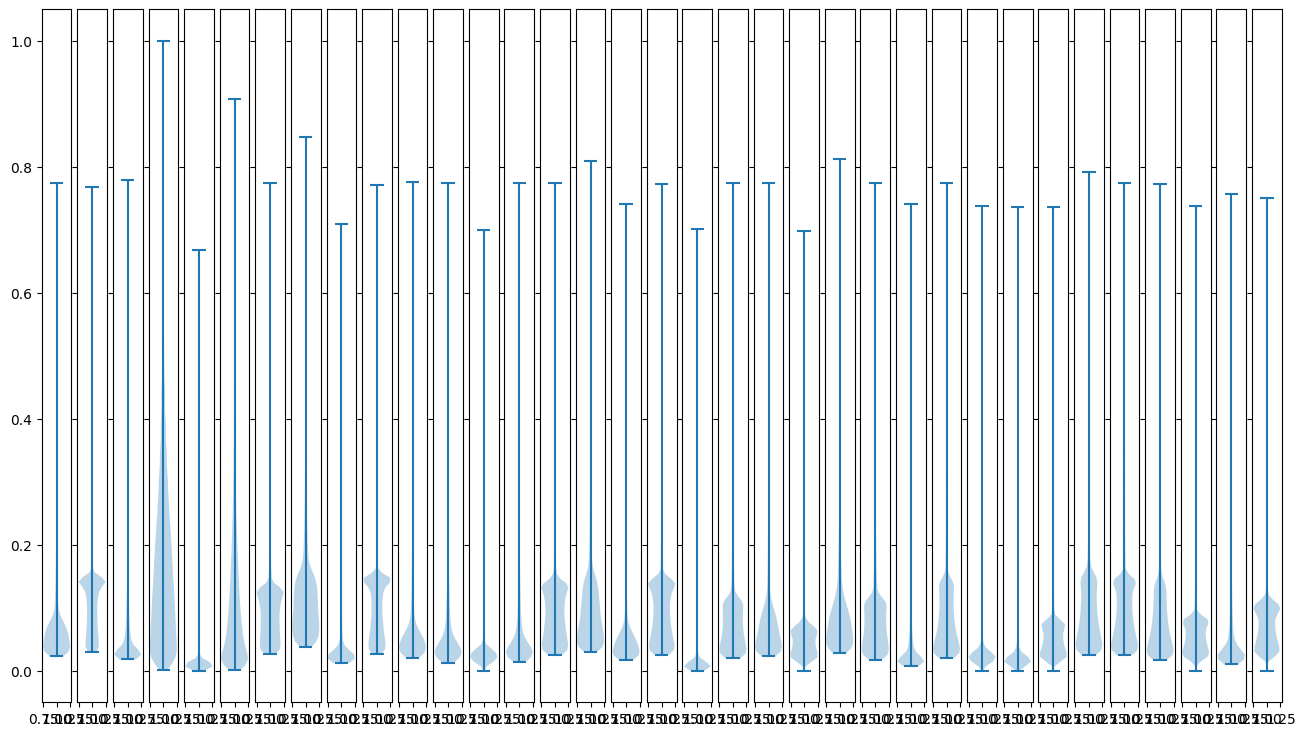

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=35, sharey=True, figsize=(16, 9))
for plot_num in range(35):
    ax[plot_num].violinplot(drought_drizzle_direct_df.reset_index(level=['trial','day']).loc[plot_num][['soil_sat']])

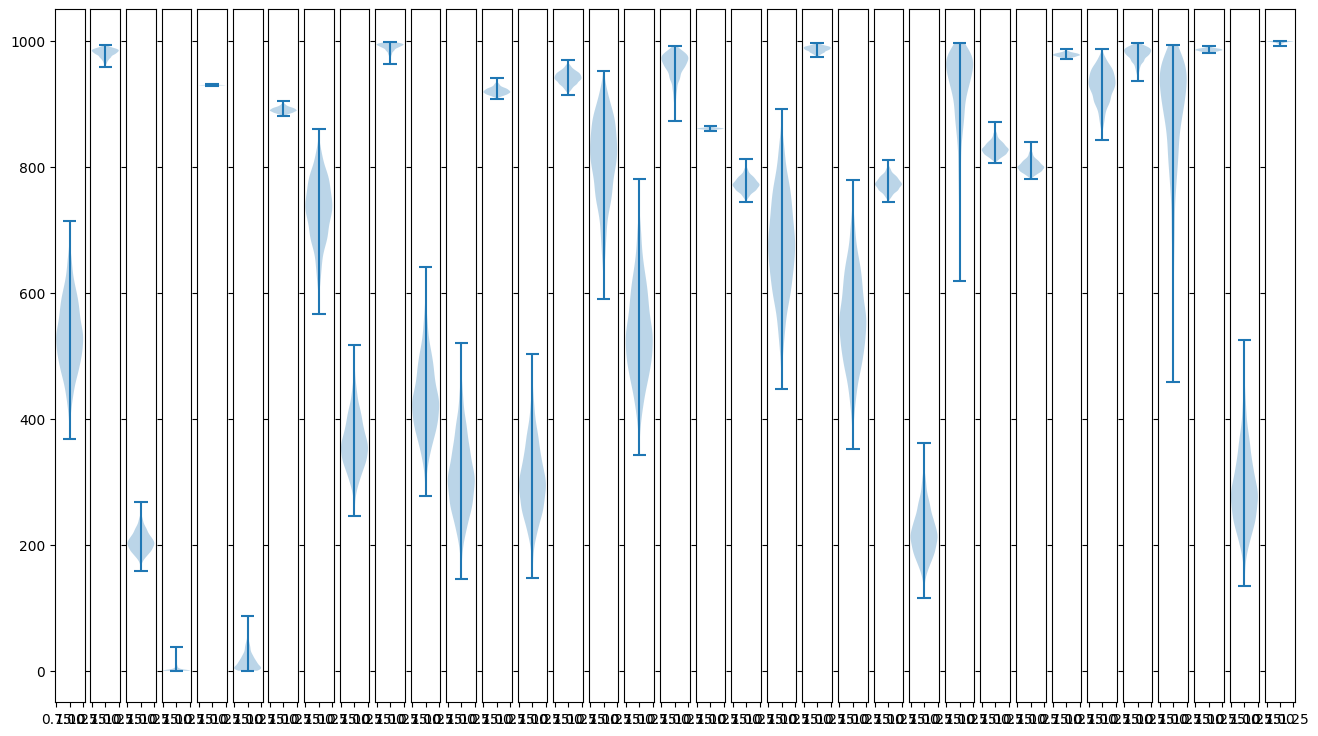

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=35, sharey=True, figsize=(16,9))
for plot_ind in range(35):
    ax[plot_ind].violinplot(drought_drizzle_direct_df.reorder_levels(['day', 'plot_index','trial']).loc[199].loc[plot_ind][['soil_sat']])
    fig.suptitle("Drought w/o Niches: 

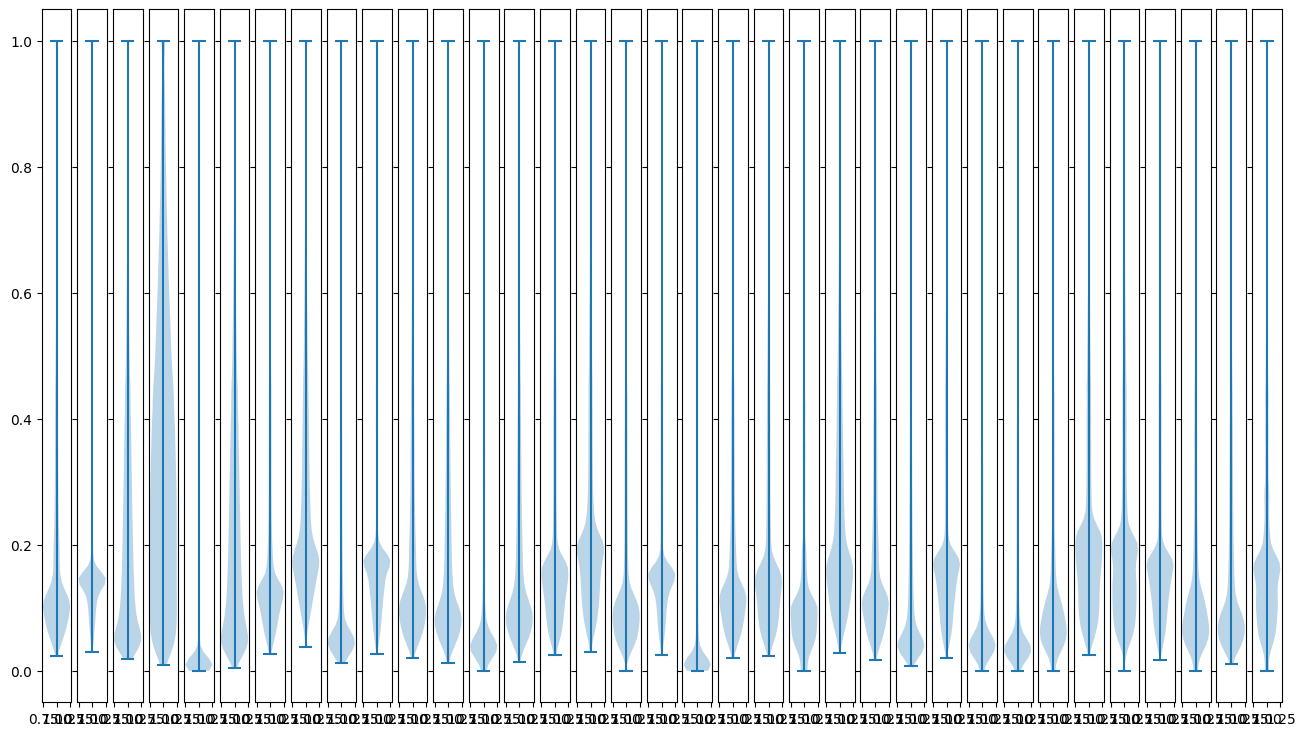

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=35, sharey=True, figsize=(16, 9))
for plot_num in range(35):
    ax[plot_num].violinplot(control_niches_df.reset_index(level=['trial','day']).loc[plot_num][['soil_sat']])

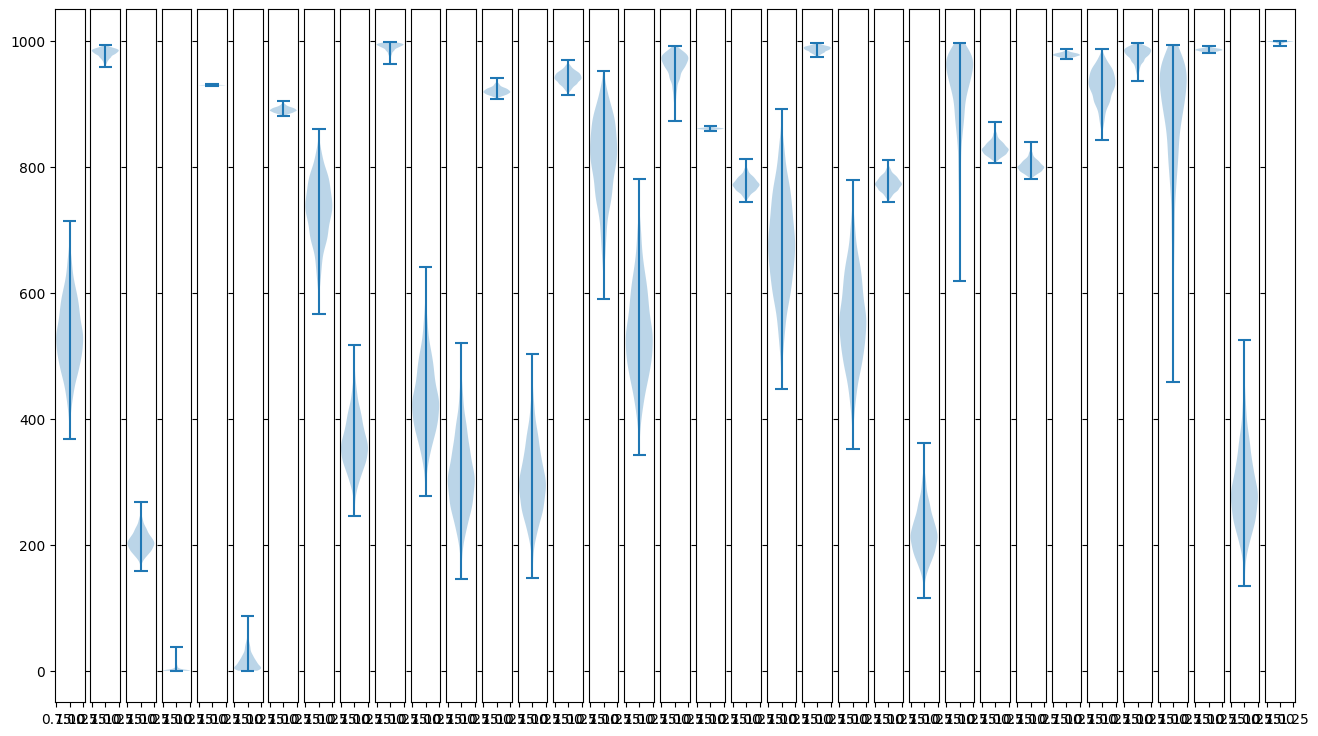

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=35, sharey=True, figsize=(16,9))
for plot_ind in range(35):
    ax[plot_ind].violinplot(drought_drizzle_direct_df.reorder_levels(['day', 'plot_index','trial']).loc[199].loc[plot_ind][['control_biomass', 'Speedy_biomass','Pokey_biomass','Swampy_biomass','Dusty_biomass','Fussy_biomass','Chill_biomass','Rudy_biomass','Leif_biomass']].sum(axis='columns'))

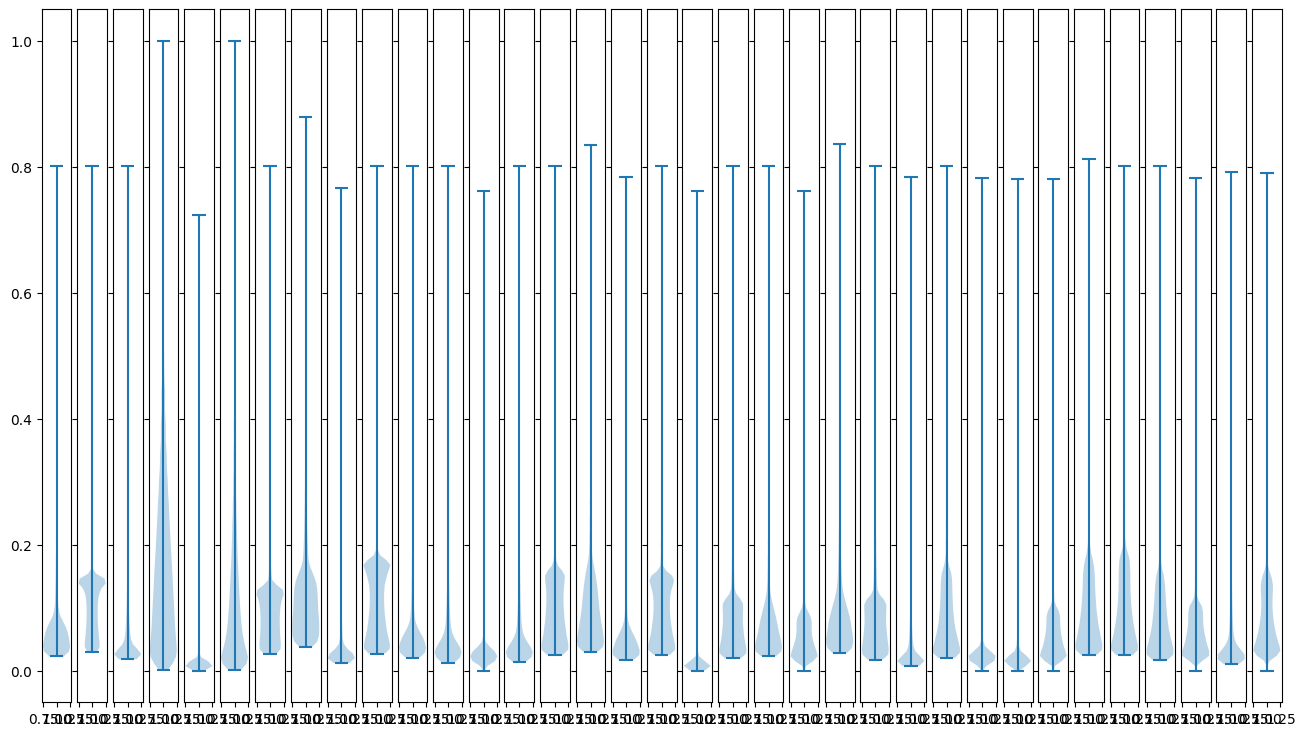

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=35, sharey=True, figsize=(16, 9))
for plot_num in range(35):
    ax[plot_num].violinplot(drought_drizzle_niches_df.reset_index(level=['trial','day']).loc[plot_num][['soil_sat']])

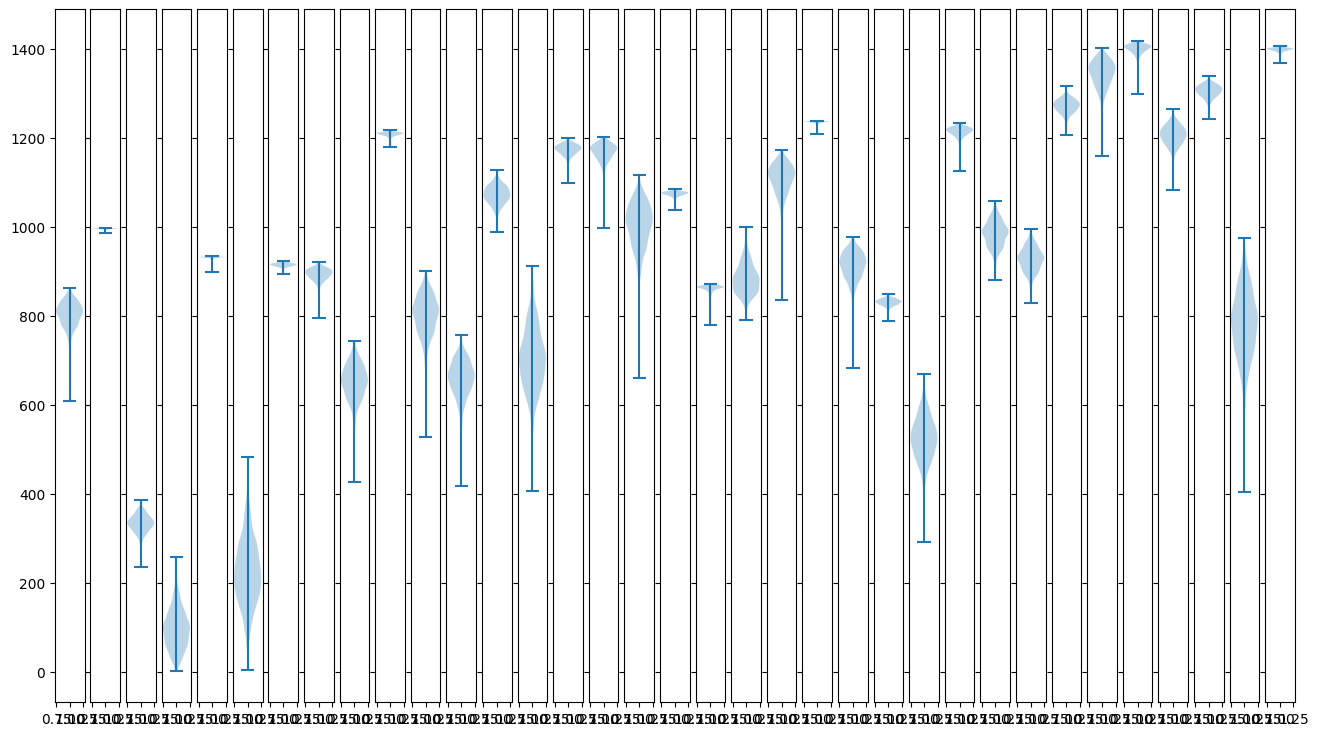

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=35, sharey=True, figsize=(16,9))
for plot_ind in range(35):
    ax[plot_ind].violinplot(control_niches_df.reorder_levels(['day', 'plot_index','trial']).loc[199].loc[plot_ind][['control_biomass', 'Speedy_biomass','Pokey_biomass','Swampy_biomass','Dusty_biomass','Fussy_biomass','Chill_biomass','Rudy_biomass','Leif_biomass']].sum(axis='columns'))

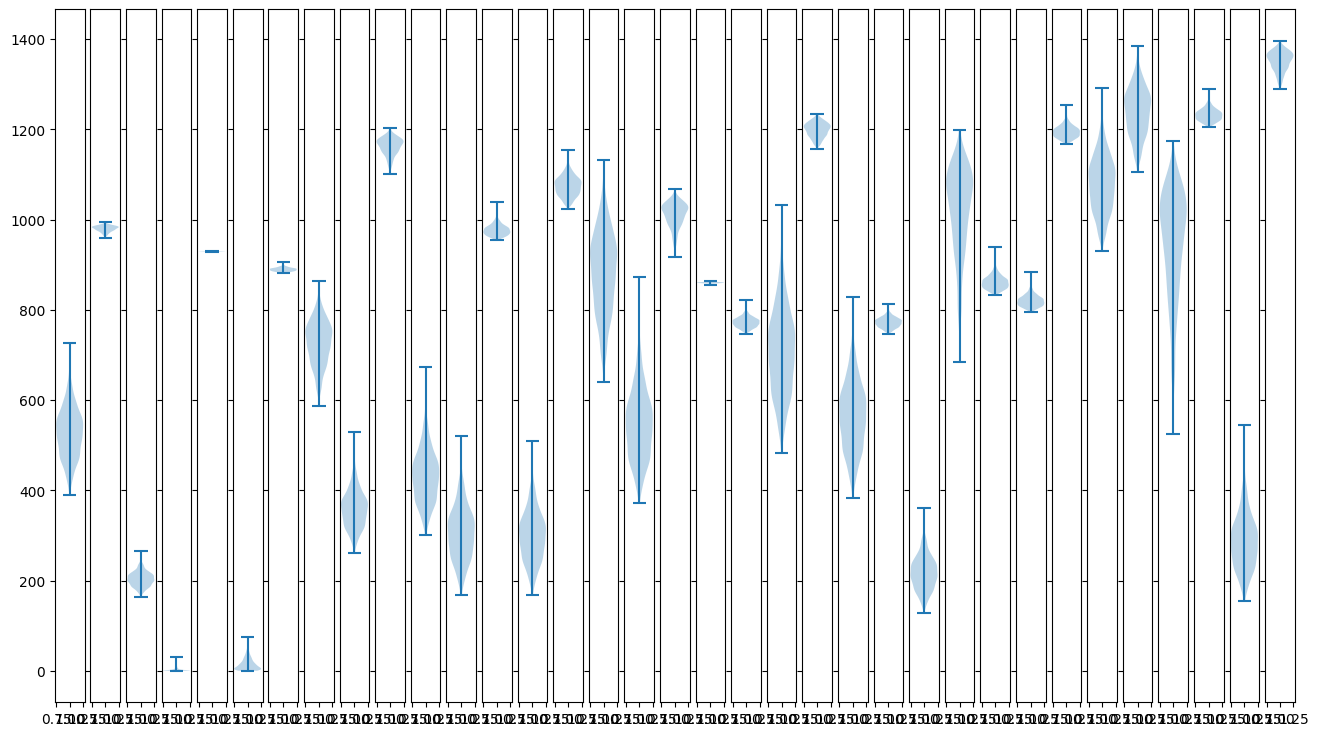

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=35, sharey=True, figsize=(16,9))
for plot_ind in range(35):
    ax[plot_ind].violinplot(drought_drizzle_niches_df.reorder_levels(['day', 'plot_index','trial']).loc[199].loc[plot_ind][['control_biomass', 'Speedy_biomass','Pokey_biomass','Swampy_biomass','Dusty_biomass','Fussy_biomass','Chill_biomass','Rudy_biomass','Leif_biomass']].sum(axis='columns'))

In [ ]:
for plot_index in range(36):
    subdf = control_niches_df.reorder_levels(['trial', 'plot_index','day']).loc[0].loc[plot_index]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10.5,8))
    fig_plants = []
    for col in subdf[['control_biomass', 'Speedy_biomass', 'Pokey_biomass', 'Swampy_biomass', 'Dusty_biomass', 'Fussy_biomass', 'Chill_biomass', 'Rudy_biomass', 'Leif_biomass']].columns.to_list():
        if subdf.loc[0][col] > 0:
            fig_plants.append(col)
    subdf['soil_sat'].plot(ax=ax[0], ylim=(0, 1))
    subdf[fig_plants].plot(ax=ax[1], ylim=(0, 1000))
    fig.suptitle('Soil Saturation and Biomass for Plot ' + str(plot_index), fontsize=16)
    ax[0].set_title('Soil Saturation')
    ax[0].set_xlabel('Time (days)')
    ax[0].set_ylabel('Soil Saturation ( 0 – 1 )')
    ax[1].set_title('Biomass')
    ax[1].set_xlabel('Time (days)')
    ax[1].set_ylabel('Biomass (biomass units)')
    plt.show()
    #plt.savefig('plot_' + str(plot_index) + '.png')
    plt.close()

In [ ]:
for plot_index in range(36):
    subdf = drought_drizzle_niches_df.reorder_levels(['trial', 'plot_index','day']).loc[0].loc[plot_index]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10.5,8))
    fig_plants = []
    for col in subdf[['control_biomass', 'Speedy_biomass', 'Pokey_biomass', 'Swampy_biomass', 'Dusty_biomass', 'Fussy_biomass', 'Chill_biomass', 'Rudy_biomass', 'Leif_biomass']].columns.to_list():
        if subdf.loc[0][col] > 0:
            fig_plants.append(col)
    subdf['soil_sat'].plot(ax=ax[0], ylim=(0, 1))
    subdf[fig_plants].plot(ax=ax[1], ylim=(0, 1000))
    fig.suptitle('Soil Saturation and Biomass for Plot ' + str(plot_index), fontsize=16)
    ax[0].set_title('Soil Saturation')
    ax[0].set_xlabel('Time (days)')
    ax[0].set_ylabel('Soil Saturation ( 0 – 1 )')
    ax[1].set_title('Biomass')
    ax[1].set_xlabel('Time (days)')
    ax[1].set_ylabel('Biomass (biomass units)')
    plt.show()
    #plt.savefig('plot_' + str(plot_index) + '.png')
    plt.close()

In [61]:
drought_drizzle_niches_df.reorder_levels(['trial','day','plot_index']).loc[0].loc[199][['control_biomass', 'Speedy_biomass', 'Pokey_biomass',
       'Swampy_biomass', 'Dusty_biomass', 'Fussy_biomass', 'Chill_biomass',
       'Rudy_biomass', 'Leif_biomass']].transpose().sum()

plot_index
0      519.387674
1      979.355039
2      203.736229
3        2.033459
4      929.305866
5       17.867015
6      888.556047
7      724.314154
8      353.197612
9     1161.406168
10     423.147388
11     304.398126
12     973.848018
13     298.205310
14    1069.592662
15     872.012545
16     530.305908
17    1010.309594
18     860.496368
19     770.854907
20     689.836806
21    1195.216190
22     554.395955
23     770.743710
24     217.146682
25    1027.200538
26     857.465738
27     817.190029
28    1190.869614
29    1069.759141
30    1231.294396
31     955.673571
32    1228.282361
33     282.657004
34    1349.171266
35    1382.091081
dtype: float64

In [81]:
control_niches_df.reorder_levels(['day', 'trial', 'plot_index',]).loc[199][['control_biomass', 'Speedy_biomass', 'Pokey_biomass',
       'Swampy_biomass', 'Dusty_biomass', 'Fussy_biomass', 'Chill_biomass',
       'Rudy_biomass', 'Leif_biomass']].pivot_table(columns='plot_index').sum() - drought_drizzle_niches_df.reorder_levels(['day', 'trial', 'plot_index',]).loc[199][['control_biomass', 'Speedy_biomass', 'Pokey_biomass',
       'Swampy_biomass', 'Dusty_biomass', 'Fussy_biomass', 'Chill_biomass',
       'Rudy_biomass', 'Leif_biomass']].pivot_table(columns='plot_index').sum()

plot_index
0     269.242870
1      14.854026
2     128.627181
3      91.654786
4       0.885608
5     201.008849
6      24.573443
7     157.677535
8     290.532418
9      42.949734
10    364.999969
11    348.580274
12     95.090990
13    403.227228
14     96.663407
15    270.833894
16    448.711763
17     59.254840
18     -2.263061
19    114.326722
20    387.167161
21     33.695325
22    337.918396
23     57.359319
24    306.268224
25    175.712993
26    122.990458
27    106.686636
28     76.242902
29    257.248595
30    151.992500
31    241.996579
32     71.988949
33    494.096492
34     43.415276
35     88.793699
dtype: float64

In [64]:
(control_niches_df.reorder_levels(['trial','day','plot_index']).loc[0].loc[199][['control_biomass', 'Speedy_biomass', 'Pokey_biomass',
       'Swampy_biomass', 'Dusty_biomass', 'Fussy_biomass', 'Chill_biomass',
       'Rudy_biomass', 'Leif_biomass']].transpose().sum()) - (drought_drizzle_niches_df.reorder_levels(['trial','day','plot_index']).loc[0].loc[199][['control_biomass', 'Speedy_biomass', 'Pokey_biomass',
       'Swampy_biomass', 'Dusty_biomass', 'Fussy_biomass', 'Chill_biomass',
       'Rudy_biomass', 'Leif_biomass']].transpose().sum())

plot_index
0     264.641510
1      16.595005
2     118.430913
3     112.327422
4      -0.109334
5     202.853305
6      23.508742
7     156.215018
8     277.333616
9      47.007271
10    343.424301
11    317.676679
12     89.857249
13    348.803931
14     97.408892
15    280.461835
16    445.989266
17     63.138603
18    -12.479804
19     84.417270
20    396.013559
21     40.561881
22    329.082952
23     52.043289
24    274.186243
25    181.794315
26     93.790234
27     77.465906
28     72.074311
29    249.804867
30    164.027830
31    236.412074
32     70.341257
33    432.308339
34     49.442295
35     94.858090
dtype: float64

In [65]:
np.mean([264.641510, 16.595005, 118.430913, 112.327422, -0.109334, 202.853305, 23.508742, 156.215018, 277.333616])

130.19957744444446

In [ ]:
#Box-Whisker of Biomass for each plant for trials

In [6]:
#Initialize monoculture plots

plot_list = [csj.Plot([copy.deepcopy(plant)], plot_capacity, initial_soil_sat, base_soil_sat_loss_rate) for plant in csj.plant_list]

#Initialize random two-plant combo plots
combos = [copy.deepcopy(list(result)) for result in itertools.combinations(csj.plant_list, 2)]
used_list = []
while len(plot_list) < 16:
    i = random.randint(0, len(combos) - 1)
    if i not in used_list:
        plot_list.append(csj.Plot(list(combos[i]), plot_capacity, initial_soil_sat, base_soil_sat_loss_rate))
        used_list.append(i)
        
#Initialize random four-plant combo plots
combos = [copy.deepcopy(list(result)) for result in itertools.combinations(csj.plant_list, 4)]
used_list = []
while len(plot_list) < 25:
    i = random.randint(0, len(combos) - 1)
    if i not in used_list:
        plot_list.append(csj.Plot(list(combos[i]), plot_capacity, initial_soil_sat, base_soil_sat_loss_rate))
        used_list.append(i)

#Initialize eight-plant plot
plot_list.append(csj.Plot(csj.plant_list, plot_capacity, initial_soil_sat, base_soil_sat_loss_rate))

#Set starting biomass for each plant in each plot
          
for plot in plot_list:
    for plant in plot.plant_list:
        plant.biomass = (initial_plot_biomass/len(plot.plant_list))

In [ ]:
for plot_index in range(len(plot_list)):
    print(f'Plot {plot_index}')
    for plant in plot_list[plot_index].plant_list:
        print(f'{plant.name}\t{plant.biomass}')

In [3]:
control_direct_df = pd.read_csv('control_with_direct_comp.csv', index_col=['plot_index','trial','day'])

In [4]:
drought_drizzle_direct_df = pd.read_csv('drought_drizzle_direct_comp.csv', index_col=['plot_index','trial','day'])
control_niches_df = pd.read_csv('control_with_niches.csv', index_col=['plot_index','trial','day'])
drought_drizzle_niches_df = pd.read_csv('drought_drizzle_niches.csv', index_col=['plot_index','trial','day'])

In [5]:
#The summary stats averaging each plots performance (each plants biomass) across the 1000 trials
control_direct_df['total_biomass']

soil_sat  control_biomass  Speedy_biomass  \
day plot_index trial                                              
0   0          0      0.441800       102.249613             NaN   
    1          0      0.441800              NaN      104.499226   
    2          0      0.441800              NaN             NaN   
    3          0      0.441800              NaN             NaN   
    4          0      0.395315              NaN             NaN   
...                        ...              ...             ...   
199 31         999    0.149756       219.072273      723.677211   
    32         999    0.097081       205.736821             NaN   
    33         999    0.085015       349.928527             NaN   
    34         999    0.130271       153.237911      481.608430   
    35         999    0.130101        94.511419      387.539839   

                      Pokey_biomass  Swampy_biomass  Dusty_biomass  \
day plot_index trial                                                 
0   0          0                NaN             NaN            NaN   
    1          0                NaN             NaN            NaN   
    2          0         100.899845             NaN            NaN   
    3          0                NaN      101.945488            NaN   
    4          0                NaN             NaN     102.234951   
...                             ...             ...            ...   
199 31         999              NaN        0.686435            NaN   
    32         999        66.277301             NaN     384.672009   
    33         999              NaN        0.041298            NaN   
    34         999              NaN             NaN     213.511056   
    35         999        28.675766        0.237808     147.453284   

                      Fussy_biomass  Chill_biomass  Rudy_biomass  Leif_biomass  
day plot_index trial                                                            
0   0          0                NaN            NaN           NaN           NaN  
    1          0                NaN            NaN           NaN           NaN  
    2          0                NaN            NaN           NaN           NaN  
    3          0                NaN            NaN           NaN           NaN  
    4          0                NaN            NaN           NaN           NaN  
...                             ...            ...           ...           ...  
199 31         999        55.026476            NaN           NaN           NaN  
    32         999              NaN     338.287626           NaN           NaN  
    33         999        11.103517            NaN           NaN     349.37035  
    34         999              NaN            NaN    151.627408           NaN  
    35         999        16.490110     138.245910     93.489811      93.35280  

[7200000 rows x 10 columns]

In [7]:
df=pd.read_csv('control_with_direct_comp_1k.csv', index_col=['plot_index'])

In [8]:
df.loc[35]

,trial,day,soil_sat,control_biomass,total_biomass,Speedy_biomass,Pokey_biomass,Swampy_biomass,Dusty_biomass,Fussy_biomass,Chill_biomass,Rudy_biomass,Leif_biomass
plot_index,,,,,,,,,,,,,
35,0,0,0.436755,11.385436,102.533999,11.659758,11.220840,11.345871,11.380490,11.385277,11.385473,11.385428,11.385427
35,0,1,0.380602,11.665649,105.099432,12.233512,11.331323,11.547741,11.660209,11.663481,11.666252,11.665633,11.665631
35,0,2,0.330919,11.950008,107.662536,12.829539,11.441847,11.700883,11.947775,11.939549,11.952971,11.949984,11.949981
35,0,3,0.287127,12.235730,110.182874,13.442442,11.551335,11.790807,12.242510,12.203849,12.244811,12.235697,12.235692
35,0,4,0.248685,12.519418,112.617700,14.064940,11.658544,11.806108,12.544414,12.444783,12.540746,12.519377,12.519371
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,999,195,0.131222,93.399896,999.993834,381.484038,28.513428,0.173140,157.882686,15.012421,138.899589,92.382009,92.246627
35,999,196,0.128283,93.400006,999.994516,381.484254,28.513470,0.172966,157.882835,15.012427,138.899721,92.382111,92.246727
35,999,197,0.128760,93.400104,999.995124,381.484446,28.513507,0.172811,157.882967,15.012434,138.899838,92.382201,92.246815


In [87]:
df=pd.read_csv('drought_drizzle_niches_1k.csv')
df = df[df['day'] == 199]
df = df[df['plot_index'] == 35]
df.head()

,plot_index,trial,day,soil_sat,control_biomass,total_biomass,Speedy_biomass,Pokey_biomass,Swampy_biomass,Dusty_biomass,Fussy_biomass,Chill_biomass,Rudy_biomass,Leif_biomass
7199,35,0,199,0.069139,84.065540,1328.714548,329.056997,26.069687,0.000071,427.587993,0.144876,294.060185,83.874444,83.854753
14399,35,1,199,0.145181,89.013175,1349.992317,342.770450,26.842116,0.000102,420.383857,0.190533,293.244117,88.786733,88.761235
21599,35,2,199,0.136895,79.683693,1309.613359,313.770972,25.400283,0.000052,436.169170,0.113744,295.448007,79.521331,79.506106
28799,35,3,199,0.137808,105.893005,1403.067043,379.987004,29.476774,0.000318,390.276999,0.469217,285.923330,105.547701,105.492696
35999,35,4,199,0.162597,114.683905,1422.486245,392.253123,30.900313,0.000568,373.811019,0.749143,281.595403,114.284100,114.208673


In [98]:
df['total_biomass'].describe()

count    1000.000000
mean     1388.551459
std        43.145703
min      1259.425412
25%      1361.765700
50%      1395.275518
75%      1420.490297
max      1470.081419
Name: total_biomass, dtype: float64